<a href="https://colab.research.google.com/github/amd257/COVID-detection-using-CNNs/blob/main/Parallel_Sequential_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Compressed Dataset file is stored at: https://www.dropbox.com/s/960snngb5e4wlld/DatasetBinaryClassification.zip?dl=0

!wget https://www.dropbox.com/s/960snngb5e4wlld/DatasetBinaryClassification.zip?dl=0

--2021-02-25 10:05:48--  https://www.dropbox.com/s/960snngb5e4wlld/DatasetBinaryClassification.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/960snngb5e4wlld/DatasetBinaryClassification.zip [following]
--2021-02-25 10:05:48--  https://www.dropbox.com/s/raw/960snngb5e4wlld/DatasetBinaryClassification.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd513777b7222b66cbb91ef163c.dl.dropboxusercontent.com/cd/0/inline/BJmH6JWEDsho_OXbLfLifQHHWGy56PWaS0L9sT2zV355SeAasoxp7jCBvAyMKU5vRtD0RKVuD9flWPLWb9IQAP4zxp0ZBmUdTosaAYRRpT7tMl0lS2mQRM3O9JgW5yXjnb4/file# [following]
--2021-02-25 10:05:49--  https://ucd513777b7222b66cbb91ef163c.dl.dropboxusercontent.com/cd/0/inline/BJmH6JWEDsho_OXbLfLifQHHWGy56PWaS0L9sT2zV355SeAas

In [3]:
#Extracting the compressed dataset
!unzip /content/DatasetBinaryClassification.zip?dl=0

Archive:  /content/DatasetBinaryClassification.zip?dl=0
   creating: DatasetBinaryClassification/
   creating: DatasetBinaryClassification/Test/
   creating: DatasetBinaryClassification/Test/COVID/
  inflating: DatasetBinaryClassification/Test/COVID/COVID (1014).png  
  inflating: DatasetBinaryClassification/Test/COVID/COVID (1033).png  
  inflating: DatasetBinaryClassification/Test/COVID/COVID (1051).png  
  inflating: DatasetBinaryClassification/Test/COVID/COVID (1056).png  
  inflating: DatasetBinaryClassification/Test/COVID/COVID (1064).png  
  inflating: DatasetBinaryClassification/Test/COVID/COVID (1067).png  
  inflating: DatasetBinaryClassification/Test/COVID/COVID (1075).png  
  inflating: DatasetBinaryClassification/Test/COVID/COVID (1089).png  
  inflating: DatasetBinaryClassification/Test/COVID/COVID (110).png  
  inflating: DatasetBinaryClassification/Test/COVID/COVID (1103).png  
  inflating: DatasetBinaryClassification/Test/COVID/COVID (1116).png  
  inflating: DatasetBi

In [4]:
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing import image
from keras.layers import *
from keras.models import *
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np

In [5]:
train_images_path = "DatasetBinaryClassification/Train"
validation_images_path = "DatasetBinaryClassification/Validation"
test_images_path = "DatasetBinaryClassification/Test"

In [19]:
#Training data augmentation before feeding it to the CNN model
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,  #flipping will add more variations to the data and it will help fight overfitting as welll
    )

#Preprocessing the training data
train_generator= train_datagen.flow_from_directory(
    train_images_path,
    target_size = (100,100),
    batch_size = 32,
    color_mode="grayscale",
    class_mode = "binary",
    shuffle = True,
    seed =40
    )

train_generator.class_indices
train_generator.image_shape

Found 2034 images belonging to 2 classes.


(100, 100, 1)

In [20]:
validation_dataset = image.ImageDataGenerator(rescale = 1./255) #Rescaling the validation images 

#Preprocessing the validation dataset
validation_generator = validation_dataset.flow_from_directory(
    validation_images_path,
    target_size = (100,100),
    batch_size = 32,
    color_mode = "grayscale" ,
    class_mode = "binary",
    shuffle = True,
    seed =40
    )

validation_generator.class_indices

Found 254 images belonging to 2 classes.


{'COVID': 0, 'Non-COVID': 1}

In [21]:
#Creating the parallel sequential model
input_shape = train_generator.image_shape
input=Input(shape = input_shape) 
# used to be (256,256,1) but that led to too many parameters, changed to (100,100,1) and model runs fine now
convs=[]
parrallel_kernels=[3,5,7]

for i in range(len(parrallel_kernels)):
  conv = Conv2D(128, parrallel_kernels[i],padding = 'same',activation='relu',input_shape=input_shape,strides=1)(input)
  convs.append(conv)

output = Concatenate()(convs)
conv_model = Model(input,output)

print(input_shape)
print(input)

(100, 100, 1)
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [22]:
model = Sequential()
model.add(conv_model) # Added the conv_model with the parallel kernels to the sequential model

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid')) #check out sigmoid as well
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 100, 100, 384)     11008     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 98, 98, 64)        221248    
_________________________________________________________________
activation_2 (Activation)    (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 47, 47, 32)        18464     
_________________________________________________________________
activation_3 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 32)       

(None, 100, 100, 1)


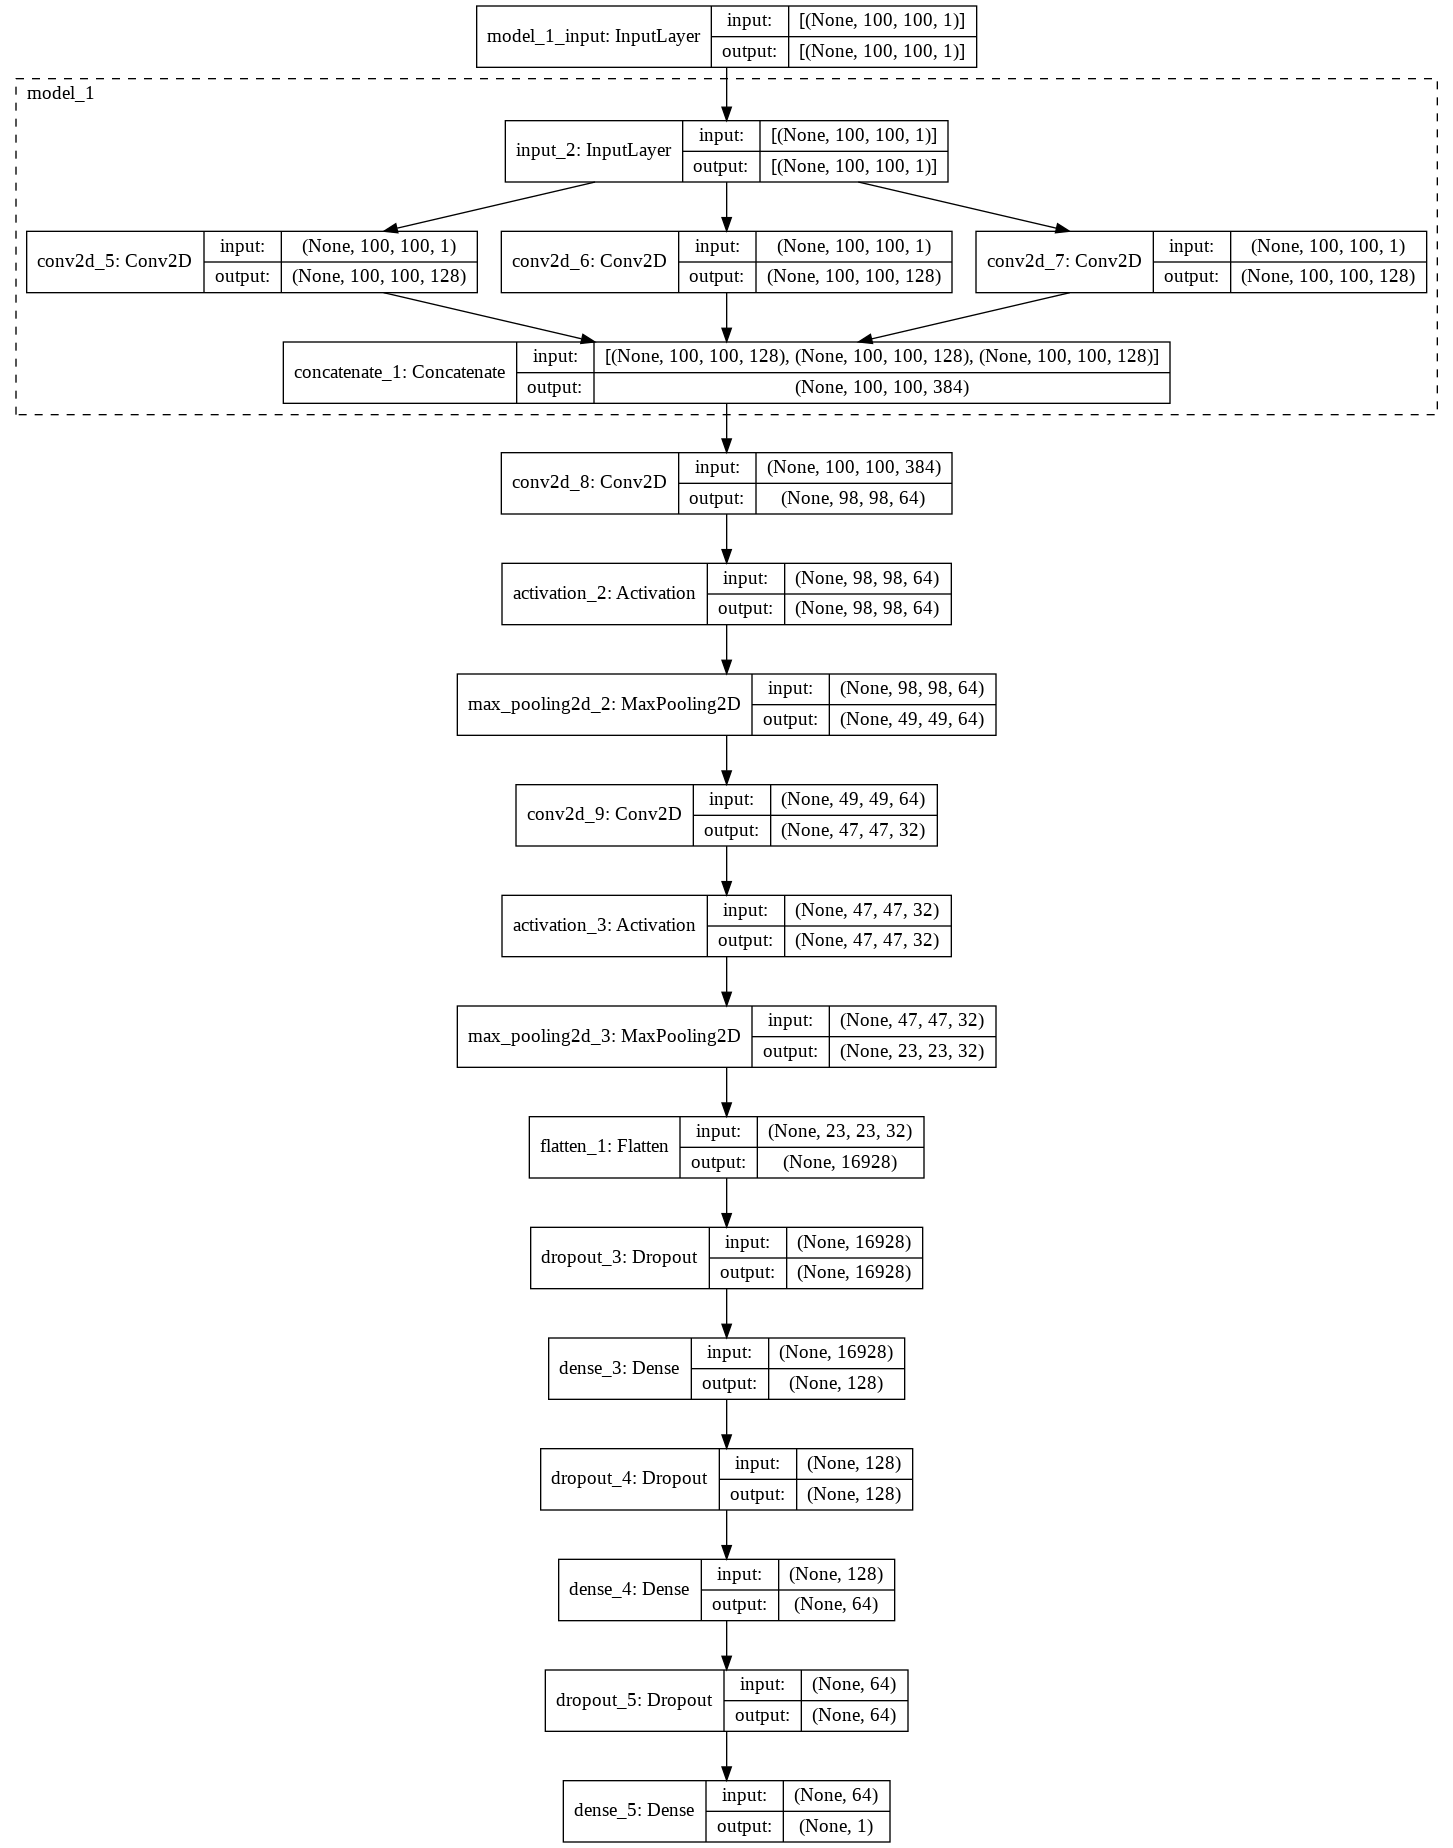

In [23]:
print(model.input.shape)
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [25]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

63
7


In [27]:
history = model.fit(
    train_generator, 
    steps_per_epoch = STEP_SIZE_TRAIN, 
    epochs=25,
    validation_data = validation_generator,
    validation_steps = STEP_SIZE_VALID
    )

Epoch 1/25
63/63 [==============================] - 26s 379ms/step - loss: 0.6277 - accuracy: 0.6231 - val_loss: 0.2072 - val_accuracy: 0.9330
Epoch 2/25
63/63 [==============================] - 23s 369ms/step - loss: 0.2528 - accuracy: 0.9213 - val_loss: 0.1721 - val_accuracy: 0.9464
Epoch 3/25
63/63 [==============================] - 23s 370ms/step - loss: 0.1924 - accuracy: 0.9289 - val_loss: 0.1257 - val_accuracy: 0.9598
Epoch 4/25
63/63 [==============================] - 23s 363ms/step - loss: 0.1967 - accuracy: 0.9264 - val_loss: 0.1159 - val_accuracy: 0.9643
Epoch 5/25
63/63 [==============================] - 23s 366ms/step - loss: 0.2159 - accuracy: 0.9267 - val_loss: 0.1177 - val_accuracy: 0.9688
Epoch 6/25
63/63 [==============================] - 23s 371ms/step - loss: 0.1807 - accuracy: 0.9370 - val_loss: 0.0877 - val_accuracy: 0.9732
Epoch 7/25
63/63 [==============================] - 24s 376ms/step - loss: 0.1473 - accuracy: 0.9474 - val_loss: 0.1000 - val_accuracy: 0.9688

In [28]:
model.save('Par_Seq_Model_Binary.h5')

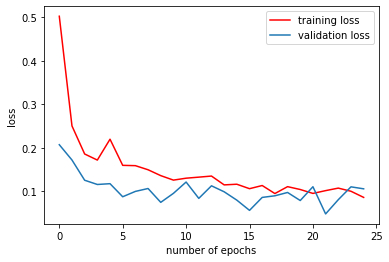

In [29]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

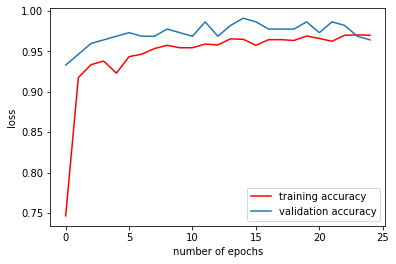

In [30]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()